In [1]:
using HDF5
using LinearAlgebra
using Statistics
include("LiPoSID.jl")

Main.LiPoSID

In [2]:
file_name = "C:/Users/Zakhar/Documents/GitHub/JPOP_SID/LiPoSID_clust_compare_methods_started_2022-Jul-15_at_15-12.h5"

"C:/Users/Zakhar/Documents/GitHub/JPOP_SID/LiPoSID_clust_compare_methods_started_2022-Jul-15_at_15-12.h5"

In [3]:
function get_seeds_and_timespan(file_name)   
    h5open(file_name,"r") do fid   # read file, preserve existing contents
        seeds = read(fid["seeds"])
        Δt = read(fid["dt"])
        tₘₐₓ = read(fid["t_max"])
        return seeds,  Δt, tₘₐₓ
    end
end

function get_noise_levels(file_name)   
    h5open(file_name,"r") do fid   # read file, preserve existing contents
        noise_levels = keys(fid["data_by_noise_level"])
        return noise_levels
    end
end

function get_variable_names(file_name, noise_level, seed)
        h5open(file_name,"r") do fid   # read file, preserve existing contents
        variable_names = keys(fid["data_by_noise_level"][string(noise_level)][string(seed)])
        return variable_names
    end
end

function get_by_name(file_name, var_name, noise_levels, seeds)
        h5open(file_name,"r") do fid # read file, preserve existing contents
        var_by_name = []
        for w in noise_levels
            current_noise_var = [ read(fid["data_by_noise_level"][string(w)][string(seed)][var_name]) for seed in seeds ]
            push!(var_by_name, current_noise_var)
        end
        return(var_by_name)
    end
end

function get_lsid(file_name, noise, seeds)
    A = get_by_name(file_name, "A", [noise], seeds)[1][1]
    C = get_by_name(file_name, "C", [noise], seeds)[1][1]
    x0 = get_by_name(file_name, "x0", [noise], seeds)[1][1]
    return A, C, x0
end

function get_kraus_sid(file_name, noise, seed)
    ρ0 = get_by_name(file_name, "rho0", [noise], seeds)[1][1]
    K1_sid = get_by_name(file_name, "K1_sid", [noise], seeds)[1][1]
    K2_sid = get_by_name(file_name, "K2_sid", [noise], seeds)[1][1]
    return ρ0, K1_sid, K2_sid
end 

get_kraus_sid (generic function with 1 method)

In [4]:
seeds,  Δt, tₘₐₓ = get_seeds_and_timespan(file_name)
noise_levels = get_noise_levels(file_name)
# get_variable_names(file_name, noise_levels[1], seeds[1])

8-element Vector{String}:
 "0.0"
 "0.01"
 "0.02"
 "0.03"
 "0.04"
 "0.05"
 "0.08"
 "0.1"

In [5]:
using QuantumOptics
basis = NLevelBasis(2)

NLevel(N=2)

In [6]:
function lindblad_evolution(key, time_limit, noise_level, seed)
    time_span = [0:Δt:time_limit;]
    H_exact = DenseOperator(basis, get_by_name(file_name, "H_"*key, [noise_level], seed)[1][1])
    J_exact = DenseOperator(basis, get_by_name(file_name, "J_"*key, [noise_level], seed)[1][1])
    ρ0 = DenseOperator(basis, get_by_name(file_name, "rho0", [noise_level], seed)[1][1])
    time, ρ_exact_ser  = timeevolution.master(time_span, ρ0, H_exact, [J_exact])
    ρ = [ρₜ.data for ρₜ in ρ_exact_ser]
end

lindblad_evolution (generic function with 1 method)

In [7]:
using Dates
res_file_name = "SID_forecasting_fidelity_" * string(Dates.format(now(), "yyyy-u-dd_at_HH-MM")) * ".h5" 
res_file_name_means = "SID_forecasting_fidelity_MEANS_" * string(Dates.format(now(), "yyyy-u-dd_at_HH-MM")) * ".h5" 

"SID_forecasting_fidelity_MEANS_2022-Aug-05_at_21-30.h5"

In [8]:
time_multipliers = [1:1:10;]
fidelity_pade = Array{Float64}(undef, length(time_multipliers), length(noise_levels))
fidelity_simp = Array{Float64}(undef, length(time_multipliers), length(noise_levels))
fidelity_lsid = Array{Float64}(undef, length(time_multipliers), length(noise_levels))
fidelity_kraus = Array{Float64}(undef, length(time_multipliers), length(noise_levels))

for m in 1:length(time_multipliers)  # time scales
    
    h5open(res_file_name,"cw") do fid   # read-write, create file if not existing, preserve existing contents
        time_multiplier_grop = create_group(fid, string(m))
        end
    
    for n in 1:length(noise_levels)
        noise = noise_levels[n]
        fid_pade = []
        fid_simp = []
        fid_lsid = []
        fid_kraus = []
        for seed in seeds #[1:2]
            time_limit = m * tₘₐₓ
            # Lindblad evolution selies "exact" and recovered
            ρ_exact = lindblad_evolution("exact", time_limit, noise, seed)
            ρ_pade = lindblad_evolution("sid_pade", time_limit, noise, seed)
            ρ_simp = lindblad_evolution("sid_simp", time_limit, noise, seed)           
            push!(fid_pade, LiPoSID.min_fidelity_between_series(basis, ρ_pade, ρ_exact))
            push!(fid_simp, LiPoSID.min_fidelity_between_series(basis, ρ_simp, ρ_exact)) 
            
            # Series recoveres by linear system identification
            time_steps = Integer(round(time_limit/Δt))+1
            A, C, x0 = get_lsid(file_name, noise, seed)
            bloch_sid = LiPoSID.propagate(A, C, x0, time_steps)
            ρ_lsid = LiPoSID.rho_series_from_bloch(bloch_sid)[1:length(ρ_exact)]
            push!(fid_lsid, LiPoSID.min_fidelity_between_series(basis, ρ_lsid, ρ_exact)) 
            
            # Series recovered with Kraus hypothesis 
            ρ0, K1_sid, K2_sid = get_kraus_sid(file_name, noise, seed)
            ρ_kraus = LiPoSID.timeevolution_kraus(time_steps, ρ0, [K1_sid, K2_sid])
            fid_kraus = LiPoSID.min_fidelity_between_series(basis, ρ_kraus, ρ_exact) 
            
        end
        
        # Write down data for all seeds
        
        h5open(res_file_name,"cw") do fid   # read-write, create file if not existing, preserve existing contents
            time_multiplier_grop = open_group(fid, string(m))
            noise_level_group = create_group(time_multiplier_grop, string(n))
            noise_level_group["fidelity_lsid"] =  convert.(Float64, fid_lsid)
            noise_level_group["fidelity_simp"] = convert.(Float64, fid_simp)
            noise_level_group["fidelity_pade"] = convert.(Float64, fid_pade)
            noise_level_group["fidelity_kraus"] = convert.(Float64, fid_kraus)
        end
        
        fidelity_pade[m,n] = mean(fid_pade)
        fidelity_simp[m,n] = mean(fid_simp)
        fidelity_lsid[m,n] = mean(fid_lsid)
        fidelity_kraus[m,n] = mean(fid_kraus)    

        end 
end

# Write down means   
h5open(res_file_name_means,"cw") do mfid   # read-write, create file if not existing, preserve existing contents
    mfid["fidelity_lsid"] = fidelity_lsid
    mfid["fidelity_simp"] = fidelity_simp
    mfid["fidelity_pade"] = fidelity_pade
    mfid["fidelity_kraus"] = fidelity_kraus
end

LoadError: HDF5.API.H5Error: Error opening group //1
libhdf5 Stacktrace:
 [1] [0m[1mH5G__loc_find_cb[22m: Symbol table/Object not found
[90m     object '1' doesn't exist[39m
  ⋮
 [9] [0m[1mH5Gopen2[22m: Symbol table/Can't open object
[90m     unable to open group[39m

In [9]:
using Plots


(process:19908): GLib-GIO-WARNING **: 21:58:54.528: Unexpectedly, UWP app `Microsoft.MSPaint_6.2203.1037.0_x64__8wekyb3d8bbwe' (AUMId `Microsoft.MSPaint_8wekyb3d8bbwe!Microsoft.MSPaint') supports 17 extensions but has no verbs


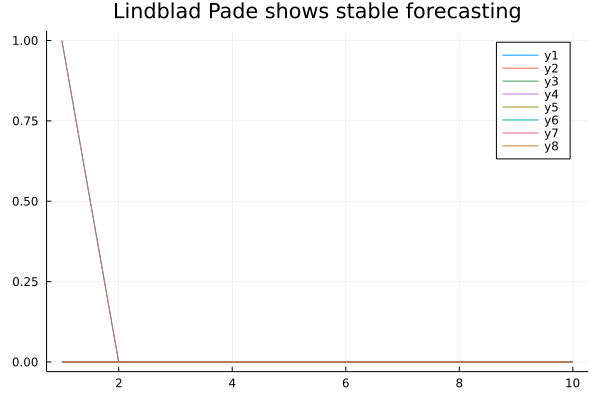

In [10]:
plot(title="Lindblad Pade shows stable forecasting")
plot!(fidelity_pade[1:end, 1])
plot!(fidelity_pade[1:end, 2])
plot!(fidelity_pade[1:end, 3])
plot!(fidelity_pade[1:end, 4])
plot!(fidelity_pade[1:end, 5])
plot!(fidelity_pade[1:end, 6])
plot!(fidelity_pade[1:end, 7])
plot!(fidelity_pade[1:end, 8])

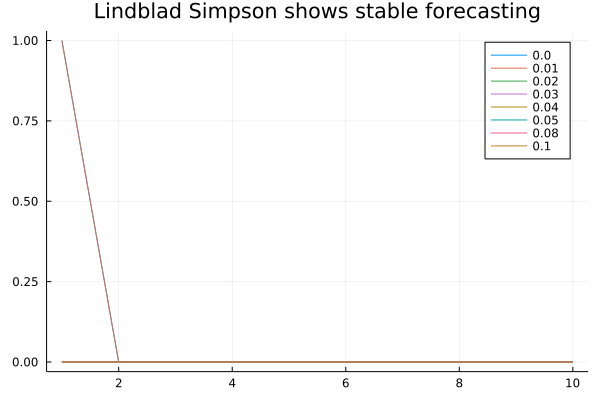

In [11]:
plot(title="Lindblad Simpson shows stable forecasting")
plot!(fidelity_simp[1:end, 1], label = noise_levels[1])
plot!(fidelity_simp[1:end, 2], label = noise_levels[2])
plot!(fidelity_simp[1:end, 3], label = noise_levels[3])
plot!(fidelity_simp[1:end, 4], label = noise_levels[4])
plot!(fidelity_simp[1:end, 5], label = noise_levels[5])
plot!(fidelity_simp[1:end, 6], label = noise_levels[6])
plot!(fidelity_simp[1:end, 7], label = noise_levels[7])
plot!(fidelity_simp[1:end, 8], label = noise_levels[8])

In [12]:
fidelity_lsid == fidelity_simp == fidelity_lsid

false

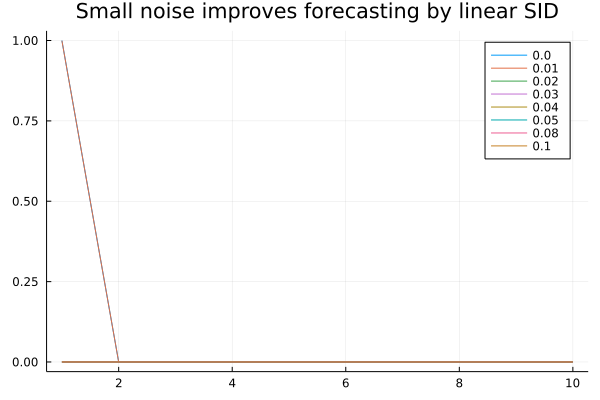

In [13]:
plot(title="Small noise improves forecasting by linear SID")
plot!(fidelity_lsid[1:end, 1], label = noise_levels[1])
plot!(fidelity_lsid[1:end, 2], label = noise_levels[2])
plot!(fidelity_lsid[1:end, 3], label = noise_levels[3])
plot!(fidelity_lsid[1:end, 4], label = noise_levels[4])
plot!(fidelity_lsid[1:end, 5], label = noise_levels[5])
plot!(fidelity_lsid[1:end, 6], label = noise_levels[6])
plot!(fidelity_lsid[1:end, 7], label = noise_levels[7])
plot!(fidelity_lsid[1:end, 8], label = noise_levels[8])

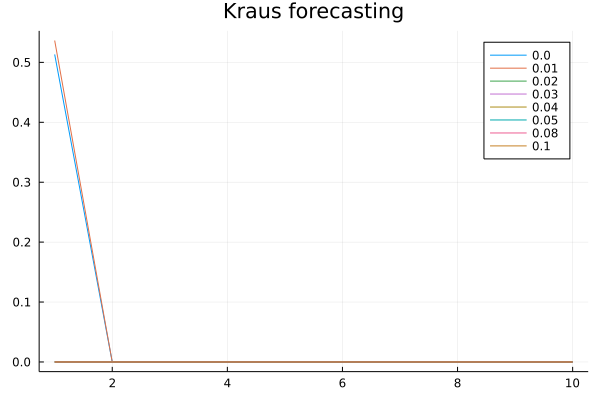

In [14]:
plot(title="Kraus forecasting")
plot!(fidelity_kraus[1:end, 1], label = noise_levels[1])
plot!(fidelity_kraus[1:end, 2], label = noise_levels[2])
plot!(fidelity_kraus[1:end, 3], label = noise_levels[3])
plot!(fidelity_kraus[1:end, 4], label = noise_levels[4])
plot!(fidelity_kraus[1:end, 5], label = noise_levels[5])
plot!(fidelity_kraus[1:end, 6], label = noise_levels[6])
plot!(fidelity_kraus[1:end, 7], label = noise_levels[7])
plot!(fidelity_kraus[1:end, 8], label = noise_levels[8])

In [15]:
function get_fidelities(file_name)   
    h5open(file_name,"r") do fid   # read file, preserve existing contents
        fidelity_lsid = read(fid["fidelity_lsid"])
        fidelity_simp = read(fid["fidelity_simp"])
        fidelity_pade = read(fid["fidelity_pade"])
        fidelity_pade = read(fid["fidelity_kraus"])
        return fidelity_lsid, fidelity_simp, fidelity_pade, fidelity_kraus
    end
end

get_fidelities (generic function with 1 method)

In [16]:
f_lsid, f_simp, f_pade, f_kraus = get_fidelities(res_file_name_means) 

LoadError: unable to determine if SID_forecasting_fidelity_MEANS_2022-Aug-05_at_21-30.h5 is accessible in the HDF5 format (file may not exist)